In [1]:
# path, venv, git bash terminal useful commands:
# cd C:/Users/marti/Desktop/AdventureWorks-msSQL-Python
# source .venv/Scripts/activate

# 1. Drivrutiner för Python och SQL connection.

In [2]:
import pyodbc
pyodbc.drivers()

['SQL Server',
 'ODBC Driver 18 for SQL Server',
 'Microsoft Access Driver (*.mdb, *.accdb)',
 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)',
 'Microsoft Access Text Driver (*.txt, *.csv)',
 'Microsoft Access dBASE Driver (*.dbf, *.ndx, *.mdx)']

# 2. Definierad Python och SQL connection samt funktion.

In [3]:
import pandas as pd
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

# quote_plus motverkar UTF-8 issues i connection.

user = "SA"
password = quote_plus(input(""))
server = "localhost:1433"
database = "AdventureWorks2025"
driver = quote_plus("ODBC Driver 18 for SQL Server")

connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)

In [4]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)

In [5]:
query_test = """
SELECT TOP 5 *
FROM Person.person
"""

query_test_df = query_df(query_test)
query_test_df.head()

C:\Users\marti\AppData\Local\Temp\ipykernel_25244\4012941776.py:2: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect() as conn:


,BusinessEntityID,PersonType,NameStyle,Title,FirstName,MiddleName,LastName,Suffix,EmailPromotion,AdditionalContactInfo,Demographics,rowguid,ModifiedDate
0,1,EM,False,None,Ken,J,Sánchez,None,0,None,"<IndividualSurvey xmlns=""http://schemas.micros...",92C4279F-1207-48A3-8448-4636514EB7E2,2020-01-07
1,2,EM,False,None,Terri,Lee,Duffy,None,1,None,"<IndividualSurvey xmlns=""http://schemas.micros...",D8763459-8AA8-47CC-AFF7-C9079AF79033,2019-01-23
2,3,EM,False,None,Roberto,None,Tamburello,None,0,None,"<IndividualSurvey xmlns=""http://schemas.micros...",E1A2555E-0828-434B-A33B-6F38136A37DE,2018-11-03
3,4,EM,False,None,Rob,None,Walters,None,0,None,"<IndividualSurvey xmlns=""http://schemas.micros...",F2D7CE06-38B3-4357-805B-F4B6B71C01FF,2018-11-27
4,5,EM,False,Ms.,Gail,A,Erickson,None,0,None,"<IndividualSurvey xmlns=""http://schemas.micros...",F3A3F6B4-AE3B-430C-A754-9F2231BA6FEF,2018-12-29


# 3. Genomgång av Uppgifter för AdventureWorks2025 db.

## 3.1 - Uppgift 1:

**Antal produkter per kategori.**

In [6]:
query_1 = """
SELECT ISNULL(ppc.Name, 'Okategoriserad') AS Kategori, 
            COUNT(pp.ProductID) AS AntalProdukter 
FROM Production.Product AS pp 
LEFT JOIN Production.ProductSubcategory AS pps 
    ON pp.ProductSubcategoryID = pps.ProductSubcategoryID 
LEFT JOIN Production.ProductCategory AS ppc 
    ON pps.ProductCategoryID = ppc.ProductCategoryID 
GROUP BY ppc.Name ORDER BY AntalProdukter DESC;"""

query_1_df = query_df(query_1) 
query_1_df

,Kategori,AntalProdukter
0,Okategoriserad,209
1,Components,134
2,Bikes,97
3,Clothing,35
4,Accessories,29


Eftersom Person.Person.ProductID är en primär nyckel med inkrement, behövs inte DISTINCT inom COUNT(pp.ProductID). COUNT-beräkningen är en aggregerad funktion som är möjliggjord via GROUP BY utav kategorinamnen. Alltså räknar count alla närvarande produkt-id i queryn och visar hur många produkter som finns per kategori.

Tack vare LEFT JOIN, med Production.Product tabellen på vänster sida, räknar `query 1` rader (produkter) som saknar ProductSubcategoryID såväl som produkter som är kategoriserade. En INNER JOIN skulle missat okategoriserade rader.

Visualisering:

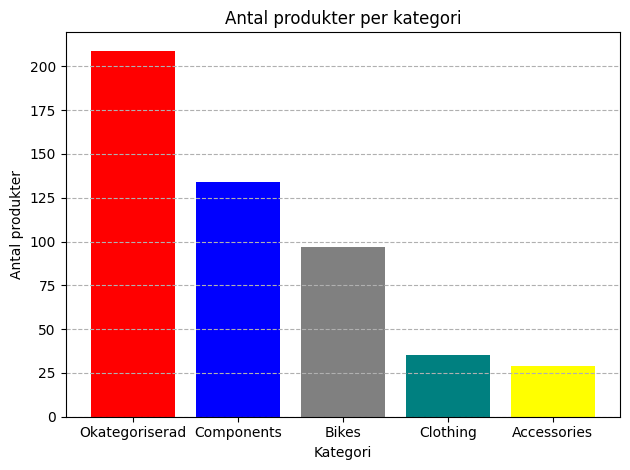


Kategori med flest produkter:
Kategori          Components
AntalProdukter           134
dtype: object

Kategori med minst produkter:
Kategori          Accessories
AntalProdukter             29
dtype: object


In [12]:
import matplotlib.pyplot as plt
colors = ['red', 'blue', 'grey', 'teal', 'yellow']
plt.bar(query_1_df.Kategori, query_1_df['AntalProdukter'], color=colors) 
plt.title("Antal produkter per kategori") 
plt.xlabel("Kategori") 
plt.ylabel("Antal produkter") 
plt.grid(True, axis='y', linestyle="--") 
plt.tight_layout() 
plt.show()

# Printa flest & minst produkter
# Sortera ut okategoriserade produkter
query_1_df_mod = query_1_df.iloc[1:,:] 
print("\nKategori med flest produkter:") 
print(query_1_df_mod.max())
print("\nKategori med minst produkter:") 
print(query_1_df_mod.min()) 

Ovan är en graf, följt av en förklaring av kategorier med flest och minst produkter.

Vid önskan om att inspektera okategoriserade produkter, körs en LEFT JOIN & WHERE IS NULL query:

In [10]:
query_1_bonus = """ 
SELECT pp.ProductID AS ProduktID, 
            pp.Name AS ProduktNamn, 
            pp.ProductSubcategoryID AS SubkategoriID, 
            pps.Name AS SubkategoriNamn, 
            ppc.Name AS KategoriNamn 
FROM Production.Product AS pp 
LEFT JOIN Production.ProductSubcategory AS pps 
    ON pp.ProductSubcategoryID = pps.ProductSubcategoryID 
LEFT JOIN Production.ProductCategory AS ppc 
    ON pps.ProductCategoryID = ppc.ProductCategoryID 
WHERE pp.ProductSubcategoryID IS NULL 
ORDER BY pp.ProductID;"""

query_1_bonus_df = query_df(query_1_bonus) 
query_1_bonus_df.tail(3)   # titta på sista 3 raderna

,ProduktID,ProduktNamn,SubkategoriID,SubkategoriNamn,KategoriNamn
206,534,Top Tube,None,None,None
207,535,Tension Pulley,None,None,None
208,679,Rear Derailleur Cage,None,None,None


Längden på resulterande tabell verkar stämma mot grafens stapel Okategoriserad.

Vidare granskning berör frekvens av kategorier med aktiva produkter. 


In [11]:
query_1_active = """ 
SELECT ISNULL(ppc.Name, 'Okategoriserad') AS Kategori, 
        COUNT(pp.ProductID) AS AntalProdukter 
FROM Production.Product AS pp 
LEFT JOIN Production.ProductSubcategory AS pps 
    ON pp.ProductSubcategoryID = pps.ProductSubcategoryID 
LEFT JOIN Production.ProductCategory AS ppc 
    ON pps.ProductCategoryID = ppc.ProductCategoryID 
WHERE pp.SellEndDate IS NULL GROUP BY ppc.Name 
ORDER BY AntalProdukter DESC; """

query_1_active_df = query_df(query_1_active) 
diff = query_1_df.AntalProdukter - query_1_active_df.AntalProdukter 
query_1_active_copy = query_1_active_df.copy() 
query_1_active_copy['Differens'] = diff 
query_1_active_copy['HistoriskaOchAktivaProdukter'] = query_1_df.AntalProdukter 
query_1_active_copy

,Kategori,AntalProdukter,Differens,HistoriskaOchAktivaProdukter
0,Okategoriserad,209,0,209
1,Components,95,39,134
2,Bikes,60,37,97
3,Accessories,22,13,35
4,Clothing,20,9,29


I resulterande tabell med tillagd kolumn Differens via python-kod (visar antalet inaktiva produkter), som givetvis skulle gå att ta fram via SQL query också, ser vi att inaktiva produkter inom Components är 39st, och så vidare. Alltså är potentiellt WHERE pp.SellEndDate IS NULL ett välbehövligt filter för query 1 ifall inaktiva produkter ska borträknas i kategoriuppdelningen.

## 3.2 Uppgift 2:

**Vilka produktkategorier genererar mest intäkter?**

In [ ]:
query_2 = """ 
SELECT ppc.Name AS Kategori, 
        SUM(ssod.LineTotal) AS TotalFörsäljning 
FROM Production.ProductCategory AS ppc 
INNER JOIN Production.ProductSubcategory AS pps 
    ON ppc.ProductCategoryID = pps.ProductCategoryID 
INNER JOIN Production.Product AS pp 
    ON pps.ProductSubcategoryID = pp.ProductSubcategoryID 
INNER JOIN Sales.SalesOrderDetail AS ssod 
    ON pp.ProductID = ssod.ProductID 
GROUP BY ppc.Name 
ORDER BY TotalFörsäljning DESC; """

query_2_df = query_df(query_2) 
query_2_df

,Kategori,TotalFörsäljning
0,Bikes,9.465117e+07
1,Components,1.180259e+07
2,Clothing,2.120543e+06
3,Accessories,1.272073e+06


Med INNER JOIN visas här nu bara data ifall försäljning har ägt rum inom SalesOrderDetail, vilket är logiskt mot affärsfrågan. Även använder vi SUM av LineTotal i SalesOrderDetail, som följer matematiska logiken $$LineTotal = UnitPrice * (1 - Discount) * Quantity.$$ Vid första anblick ser cyklar ut att driva högst intäkter.

En query med LEFT JOIN låter oss se okategoriserade produkter som har sett försäljning, för att inte missa intäkter i våra beräkningar (även om dessa kan väljas att bortses ifrån). 

In [14]:
query_2_left = """ 
SELECT pp.ProductID AS ProduktID, 
        pp.Name AS ProduktNamn, 
        pps.Name AS SubkategoriNamn, 
        ppc.Name AS KategoriNamn, 
        SUM(ssod.LineTotal) AS TotalFörsäljning 
FROM Production.Product AS pp 
LEFT JOIN Production.ProductSubcategory AS pps 
    ON pp.ProductSubcategoryID = pps.ProductSubcategoryID 
LEFT JOIN Production.ProductCategory AS ppc 
    ON pps.ProductCategoryID = ppc.ProductCategoryID 
LEFT JOIN Sales.SalesOrderDetail AS ssod 
    ON pp.ProductID = ssod.ProductID 
GROUP BY ppc.Name, pps.Name, pp.Name, pp.ProductID 
ORDER BY TotalFörsäljning DESC; """

query_2_left_df = query_df(query_2_left) 
display(query_2_left_df.tail(3)) # titta på sista 3 raderna

,ProduktID,ProduktNamn,SubkategoriNamn,KategoriNamn,TotalFörsäljning
501,679,Rear Derailleur Cage,None,None,NaN
502,680,"HL Road Frame - Black, 58",Road Frames,Components,NaN
503,706,"HL Road Frame - Red, 58",Road Frames,Components,NaN


In [15]:
# python overview av query_2_left_df
print("Här är hur många rader som saknar kategori men ändå haft försäljning: ", len(
    query_2_left_df[(query_2_left_df['KategoriNamn'].isna()) & 
                    (query_2_left_df['TotalFörsäljning'] > 0)])) # blir noll 

Här är hur många rader som saknar kategori men ändå haft försäljning:  0


Eftersom alla okategoriserade produkter har NaN i TotalFörsäljning, är slutsatsen att INNER JOIN räcker för intäktsanalysen. Okategoriserade produkter kan härstamma som prototyper, icke-lanserade, reservdelar eller produkter som används inuti företaget.

Vi gör en förfinad tabell beaktandes kategoriserade produkter, som även beräknar värden för nuvarande aktiva produkter och differens mot inklusive inaktiva produkters försäljning, alltså inräknad historik. 

In [16]:
query_2_active = """ 
SELECT ppc.Name AS Kategori, 
        SUM(ssod.LineTotal) AS TotalFörsäljning 
FROM Production.ProductCategory AS ppc 
INNER JOIN Production.ProductSubcategory AS pps 
    ON ppc.ProductCategoryID = pps.ProductCategoryID 
INNER JOIN Production.Product AS pp 
    ON pps.ProductSubcategoryID = pp.ProductSubcategoryID 
INNER JOIN Sales.SalesOrderDetail AS ssod 
    ON pp.ProductID = ssod.ProductID 
WHERE pp.SellEndDate IS NULL 
GROUP BY ppc.Name
ORDER BY TotalFörsäljning DESC;"""

query_2_active_df = query_df(query_2_active)
diff = query_2_df.TotalFörsäljning - query_2_active_df.TotalFörsäljning 
query_2_active_copy = query_2_active_df.copy() 
query_2_active_copy['Differens'] = diff.round(0).astype(int) 
query_2_active_copy['HistoriskFörsäljning'] = query_2_df.TotalFörsäljning.round(0).astype(int) 
query_2_active_copy['TotalFörsäljning'] = query_2_active_copy['TotalFörsäljning'].round(0).astype(int)

print("Här är en presentationsvänlig tabell på försäljning per kategori:") 
display(query_2_active_copy) 

Här är en presentationsvänlig tabell på försäljning per kategori:


,Kategori,TotalFörsäljning,Differens,HistoriskFörsäljning
0,Bikes,61069197,33581976,94651173
1,Components,9468393,2334200,11802593
2,Clothing,1531721,588821,2120543
3,Accessories,1242318,29755,1272073


Exakta siffrorna för högst respektive lägst försäljning, som tillfaller kategorin cyklar och accessoarer (oavsett aktivitetsfiltret):

In [ ]:
print(f"""Högst försäljning: {query_2_df.TotalFörsäljning[0]},
Och för aktiva produkter: {query_2_active_df.TotalFörsäljning[0]}""")
print("-----------------------------------------")
print(f"""Lägst försäljning: {query_2_df.TotalFörsäljning[len(query_2_df)-1]},
Och för aktiva produkter: {query_2_active_df.TotalFörsäljning[len(query_2_active_df)-1]}""") 
# len() för att ta sista indexplatsen, alltså lägsta siffran.

Högst försäljning: 94651172.704731,
Och för aktiva produkter: 61069196.787288
-----------------------------------------
Lägst försäljning: 1272072.883926,
Och för aktiva produkter: 1242317.97665


Visualisering som beaktar historiska totala-, och aktiva produkters totala försäljning:

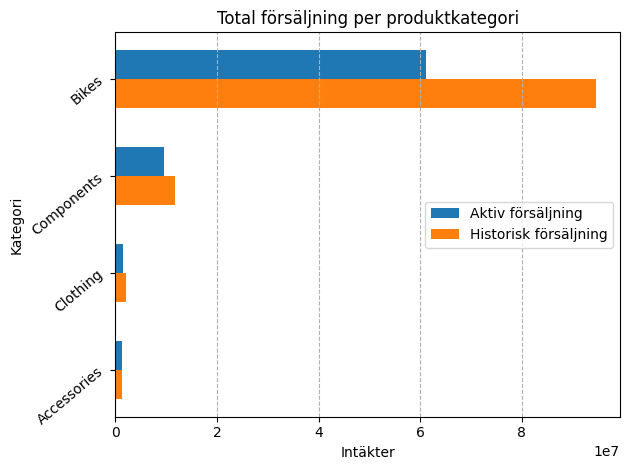

In [18]:
import numpy as np

cols = ['TotalFörsäljning','HistoriskFörsäljning'] # behöver sortera som stigande, för barh plot ska ha högst överst.
ascending_df = query_2_active_copy.copy().sort_values(by=cols, ascending=True) # använder den förfinade tabellen
categories = ascending_df['Kategori'] # plockar ut kolumner som ska plottas till variabler
active_sales = ascending_df['TotalFörsäljning']
historic_sales = ascending_df['HistoriskFörsäljning']
length = len(ascending_df) # hur många staplar ska plottas
y = np.arange(length) 
width = 0.3

plt.figure()
plt.barh(y + width/2, active_sales, width, label='Aktiv försäljning')
plt.barh(y - width/2, historic_sales, width, label='Historisk försäljning')

plt.yticks(y, categories, rotation=40)
plt.ylabel('Kategori')
plt.xlabel('Intäkter')
plt.title("Total försäljning per produktkategori")
plt.legend(loc='center right')
plt.grid(True, axis='x', linestyle="--")
plt.tight_layout()
plt.show()

Affärsinsikt:

Kategorier med högst intäkter är beroende av produkternas vinstmarginaler eller omsättningsfigurer, som tycks gås igenom i uppgift 5 (top 10 produkter), samtidigt som kostnadsstruktur är viktig för sådan analys. Cyklar är dyra vilket driver på den figuren som är högst.

Fråga 2 berör intäkter: volym och prisnivå, och inte ens över tid, vilket uppgift 3 & 4 tycks handla om. Geografisk försäljning syns till i uppgift 7.

## 3.3 Uppgift 3:

**Försäljningstrend över tid.**